开始优化 13 层膜系 (L-BFGS-B)...


C:\Users\51648\AppData\Local\Temp\ipykernel_30456\2548293020.py:84: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = minimize(



优化结束！
最终 Loss (MSE) = 0.046606
优化后的厚度 (nm):
[ 10.  ,  10.  , 116.32, 100.41, 109.05,  93.77,  56.33,  85.05,  39.54,
  69.67,  54.5 ,  98.27,  65.08]



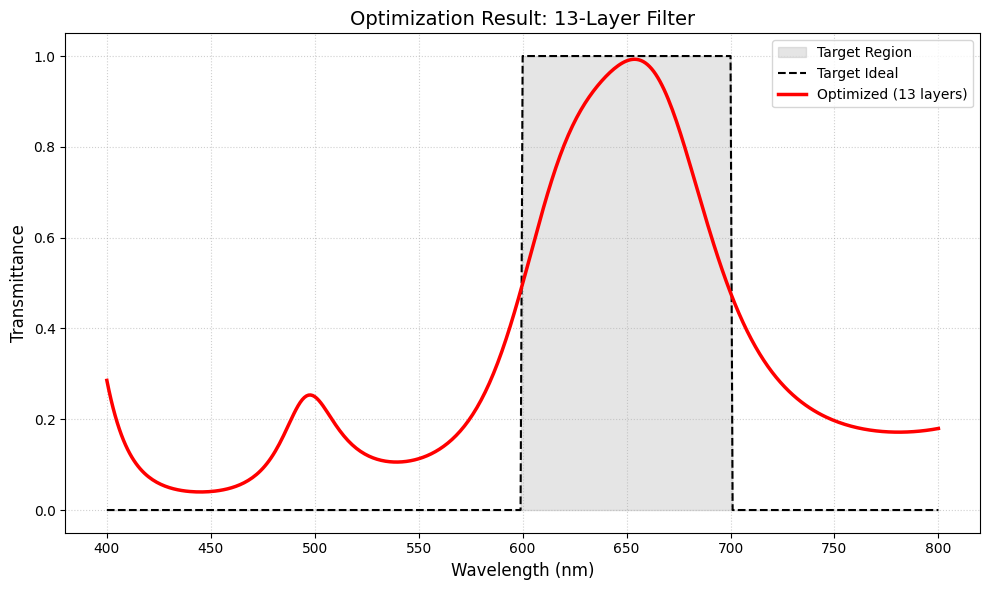

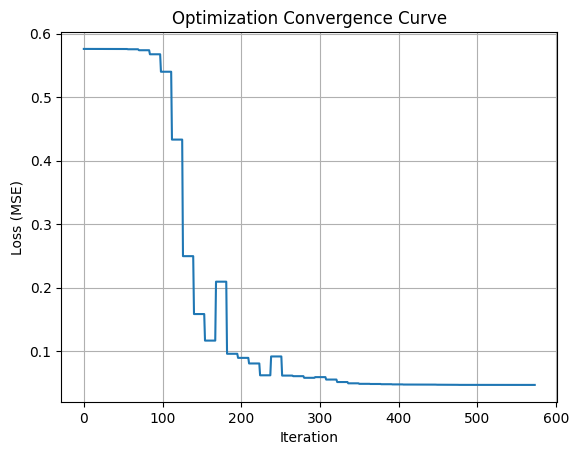

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# =================================================
# 1. 设置波长范围 + 目标光谱（红色带通）
# =================================================
lam_nm = np.linspace(400, 800, 401)

# 目标：600nm~700nm 透射率为 1 (通带)，其余为 0 (截止)
target_T = np.zeros_like(lam_nm)
target_T[(lam_nm >= 600) & (lam_nm <= 700)] = 1.0

# =================================================
# 2. 设置材料与结构 (关键修改：13层 High/Low 交替)
# =================================================
n0 = 1.0       # 空气
ns = 1.5       # 玻璃基底

# 使用高对比度折射率：TiO2 (2.35) 和 SiO2 (1.45)
n_high = 2.35
n_low  = 1.45

# 构造 13 层结构：H L H L ... H
# 更多的层数意味着更强的“整形”能力
n_stack = [n_high, n_low] * 6 + [n_high]
n_layers = np.array(n_stack)
num_layers = len(n_layers)

# 初始厚度：设为 1/4 波长附近 (约 80~100nm)
t0 = np.ones(num_layers) * 80.0

# =================================================
# 3. TMM 计算函数 (保持不变，核心算法)
# =================================================
def calculate_spectrum(t_nm, n_layers, lam_nm):
    lam_m = lam_nm * 1e-9
    d_m = t_nm * 1e-9

    T = np.empty_like(lam_m)

    for i, lam in enumerate(lam_m):
        M = np.eye(2, dtype=complex)
        k0 = 2 * np.pi / lam

        for j in range(len(n_layers)):
            n = n_layers[j]
            phi = k0 * n * d_m[j]
            # 欧拉公式展开
            cp = np.cos(phi)
            sp = np.sin(phi)

            M_layer = np.array([
                [ cp,           1j * sp / n ],
                [ 1j * n * sp,  cp ]
            ], dtype=complex)

            M = M @ M_layer

        # 计算透射系数 t
        denom = n0 * M[0,0] + n0*ns * M[0,1] + M[1,0] + ns*M[1,1]
        t_amp = 2 * n0 / denom
        T[i] = (ns/n0) * np.abs(t_amp)**2

    return T

# =================================================
# 4. 优化目标 (去掉了 smooth 正则化，纯 MSE)
# =================================================
loss_history = []

def objective(t_nm):
    T_pred = calculate_spectrum(t_nm, n_layers, lam_nm)
    mse = np.mean((T_pred - target_T)**2)
    loss_history.append(mse)
    return mse


# 限制每层厚度在 10nm ~ 500nm 之间
bounds = [(10, 500)] * num_layers

print(f"开始优化 {num_layers} 层膜系 (L-BFGS-B)...")

res = minimize(
    objective,
    t0,
    method="L-BFGS-B",
    bounds=bounds,
    options={'disp': True, 'maxiter': 500} # 增加一点迭代次数上限
)

# =================================================
# 5. 输出结果
# =================================================
t_opt = res.x
print("\n==============================")
print("优化结束！")
print(f"最终 Loss (MSE) = {res.fun:.6f}")
print("优化后的厚度 (nm):")
# 打印得整齐一点
print(np.array2string(t_opt, precision=2, separator=', ', suppress_small=True))
print("==============================\n")

# 计算最终光谱
T_opt = calculate_spectrum(t_opt, n_layers, lam_nm)

# =================================================
# 6. 绘图
# =================================================
plt.figure(figsize=(10, 6))

# 画目标区域（阴影）
plt.fill_between(lam_nm, target_T, color='gray', alpha=0.2, label='Target Region')
plt.plot(lam_nm, target_T, 'k--', linewidth=1.5, label="Target Ideal")

# 画优化结果
plt.plot(lam_nm, T_opt, 'r-', linewidth=2.5, label=f"Optimized ({num_layers} layers)")

plt.xlabel("Wavelength (nm)", fontsize=12)
plt.ylabel("Transmittance", fontsize=12)
plt.title(f"Optimization Result: {num_layers}-Layer Filter", fontsize=14)
plt.legend(loc='best')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)")
plt.title("Optimization Convergence Curve")
plt.grid(True)
plt.show()


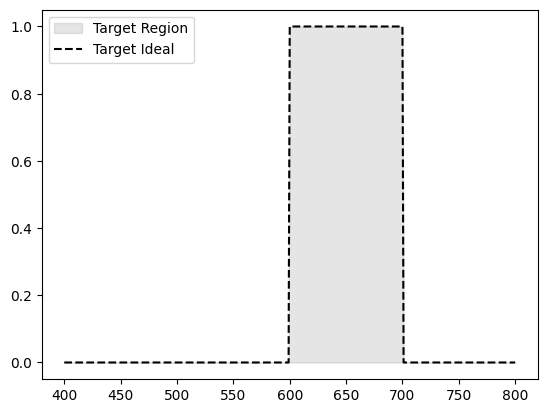

In [15]:
plt.fill_between(lam_nm, target_T, color='gray', alpha=0.2, label='Target Region')
plt.plot(lam_nm, target_T, 'k--', linewidth=1.5, label="Target Ideal")
plt.legend(loc='best')
plt.show()